# Experiments with Stanford Dogs Dataset

In this section we are going to experiment with multiple permutations of our approach. Experiments to run:
- Parallel Visual Attention Encoder for Model Improvement (FerNet)
- EfficientNetB2
- LKA using our encoding approach
- CBAM using our encoding approach

## Import libraries

In [1]:
# Import libraries
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mping
import pandas as pd
import random

In [2]:
# Create function to ploss accuracy and loss
def plotModelsCurves(history, fine_tuned_history, model_name):
    epochs = len(history.history["loss"]+fine_tuned_history.history["loss"])
    plt.figure(figsize=(20,8))

    plt.subplot(1,2, 1)
    plt.title("Loss")
    plt.plot(range(epochs), history.history["loss"]+fine_tuned_history.history["loss"],color="blue", label="Train Loss")
    plt.plot(range(epochs), history.history["val_loss"]+fine_tuned_history.history["val_loss"], color="green", label="Val Loss")
    plt.axvline(x = len(history.history["loss"]), color = 'red', label = 'Fine Tuning')    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1,2, 2)
    plt.title("Accuracy")
    plt.plot(range(epochs), history.history["accuracy"]+fine_tuned_history.history["accuracy"],color="blue", label="Train Loss")
    plt.plot(range(epochs), history.history["val_accuracy"]+fine_tuned_history.history["val_accuracy"], color="green", label="Val Loss")
    plt.axvline(x = len(history.history["accuracy"]), color = 'red', label = 'Fine Tuning')    
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.suptitle(f'{model_name}', fontsize=18);
    plt.tight_layout()

    plt.plot()

## Load Dataset

In [3]:
# Load images
seed = 42
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA

    IMG_SIZE = (260,260)
    dataset_path = "/kaggle/input/stanford-dogs-dataset-benchmark/Images"
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_path,
        validation_split=0.20,
        subset="training",
        seed=seed,
        image_size=IMG_SIZE,
        batch_size=32,
        label_mode = 'categorical')
    train_ds = train_ds.with_options(options)
    
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_path,
        validation_split=0.20,
        subset="validation",
        seed=seed,
        image_size=IMG_SIZE,
        batch_size=32,
        label_mode = 'categorical')
    class_names_array = val_ds.class_names;num_outputs = len(val_ds.class_names); val_ds = val_ds.with_options(options)

2022-12-18 22:15:02.441438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 22:15:02.442530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 22:15:02.672960: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 22:15:02.673912: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 22:15:02.674748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


##  Parallel Visual Attention Encoder for Model Improvement - FerNet

In [23]:
# fix random seed for reproducibility
tf.random.set_seed(0)
with strategy.scope():
    
    base_model = tf.keras.applications.EfficientNetB2(include_top=False)
    base_model.trainable = False
    input_shape = IMG_SIZE+(3,)
    
    inputs = tf.keras.layers.Input(shape=input_shape, name="Inputs")

    ## EfficientNet
    effNet_model = base_model(inputs, training=False)
    
    effNet_model = tf.keras.layers.GlobalAveragePooling2D()(effNet_model)
    eff_model = tf.keras.Model(inputs=inputs, outputs=effNet_model, name="EfficientNetB2")

    ## Visual Attention
    va = tf.keras.layers.Rescaling(1/255., name="Rescaling")(inputs)
    
    va = tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.gelu, strides=1, name="ConvEnconderAttention1")(va)
    va = tf.keras.layers.AveragePooling2D()(va)
    va = tf.keras.layers.Conv2D(16, 3, activation=tf.keras.activations.gelu, strides=1, name="ConvEnconderAttention2")(va)
    va = tf.keras.layers.AveragePooling2D()(va)
    
    # LKA    
    va_input = tf.keras.layers.Conv2D(12, 1, name='LKA_Projector1')(va)
    va1 = tf.keras.layers.BatchNormalization()(va_input)
    va1 = tf.keras.layers.Activation(tf.keras.activations.gelu)(va1)
    va1 = tf.keras.layers.DepthwiseConv2D(5, padding='same',name='LKA_DWProjector_Spatial1')(va1)
    va1 = tf.keras.layers.DepthwiseConv2D(7, padding='same', dilation_rate=3, name='LKA_DWProjector_Spatial2')(va1)
    va1 = tf.keras.layers.Conv2D(4, 1, name='LKA_Projector2')(va1)
    va1 = tf.keras.layers.Conv2D(12, 1, name='LKA_Projector3')(va1)
    va1 = tf.keras.layers.Add()([va1, va_input])
    # CBAM
    ## Channel Attention
    input_channels = va.get_shape()[-1]
    avg_pool_channel = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=[1,2], keepdims=True))(va)
    max_pool_channel = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=[1,2], keepdims=True))(va)
    avg_pool_channel = tf.keras.layers.Dense(input_channels//3,
                                             activation="relu", kernel_initializer='he_normal',
                                             use_bias=True,
                                             bias_initializer='zeros', name="ChannelAtt_Avg_Conv1")(avg_pool_channel)
    avg_pool_channel = tf.keras.layers.Dense(input_channels,
                                             kernel_initializer='he_normal',use_bias=True,
                                             bias_initializer='zeros', name="ChannelAtt_Avg_Conv2")(avg_pool_channel)
    max_pool_channel = tf.keras.layers.Dense(input_channels//3,
                                             activation="relu", kernel_initializer='he_normal',
                                             use_bias=True,
                                             bias_initializer='zeros', name="ChannelAtt_Max_Conv1")(max_pool_channel)
    max_pool_channel = tf.keras.layers.Dense(input_channels,
                                     kernel_initializer='he_normal',
                                     use_bias=True,
                                     bias_initializer='zeros', name="ChannelAtt_Max_Conv2")(max_pool_channel)
    channel_attention = tf.keras.layers.Add()([avg_pool_channel,max_pool_channel])
    channel_attention = tf.keras.layers.Activation("sigmoid")(channel_attention)
    channel_attention = tf.keras.layers.Multiply()([va, channel_attention])

    ## Spatial attention
    kernel_size = 7
    avg_pool_spatial = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(channel_attention)
    max_pool_spatial = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(channel_attention)
    
    spatial_attention = tf.keras.layers.Concatenate(axis=3)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = tf.keras.layers.Conv2D(filters = 1,
                                        kernel_size=kernel_size,
                                        strides=1,
                                        padding='same',
                                        activation= tf.keras.activations.sigmoid,
                                        kernel_initializer='he_normal',
                                        use_bias=False,name="SpatialAtt_Max_Conv2")(spatial_attention)
    spatial_attention = tf.keras.layers.multiply([channel_attention, spatial_attention])
    
    # Unify modules - Latent space
    va1 = tf.keras.layers.Conv2D(4, kernel_size=1)(va1)
    va2 = tf.keras.layers.Conv2D(4, kernel_size=1)(spatial_attention)
    va = tf.keras.layers.Add()([va1, va2])

    va = tf.keras.layers.Conv2D(4, kernel_size=5, strides=2,activation=tf.keras.activations.gelu, name="latent_output")(va)
    va = tf.keras.layers.AveragePooling2D()(va)
    
    va_pooling = tf.keras.layers.Flatten()(va)   
    
    # Create module
    va_model = tf.keras.Model(inputs=inputs, outputs=va_pooling)

    # Concatenate with base model
    embedded_model = tf.keras.layers.Concatenate(name="EmbeddingLayer")([eff_model.output, va_model.output])
    #embedded_model = tf.keras.layers.Dense(512, activation="relu")(embedded_model)
    embedded_model = tf.keras.layers.Dropout(rate=0.5,name="DropoutToOutput")(embedded_model)
    outputs = tf.keras.layers.Dense(num_outputs, activation="softmax", name="Output_layer")(embedded_model)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="FerNet")

    model.compile(loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.025),
                  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=["accuracy"])

In [24]:
model.summary()

Model: "FerNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             [(None, 260, 260, 3) 0                                            
__________________________________________________________________________________________________
Rescaling (Rescaling)           (None, 260, 260, 3)  0           Inputs[0][0]                     
__________________________________________________________________________________________________
ConvEnconderAttention1 (Conv2D) (None, 258, 258, 32) 896         Rescaling[0][0]                  
__________________________________________________________________________________________________
average_pooling2d_12 (AveragePo (None, 129, 129, 32) 0           ConvEnconderAttention1[0][0]     
_____________________________________________________________________________________________

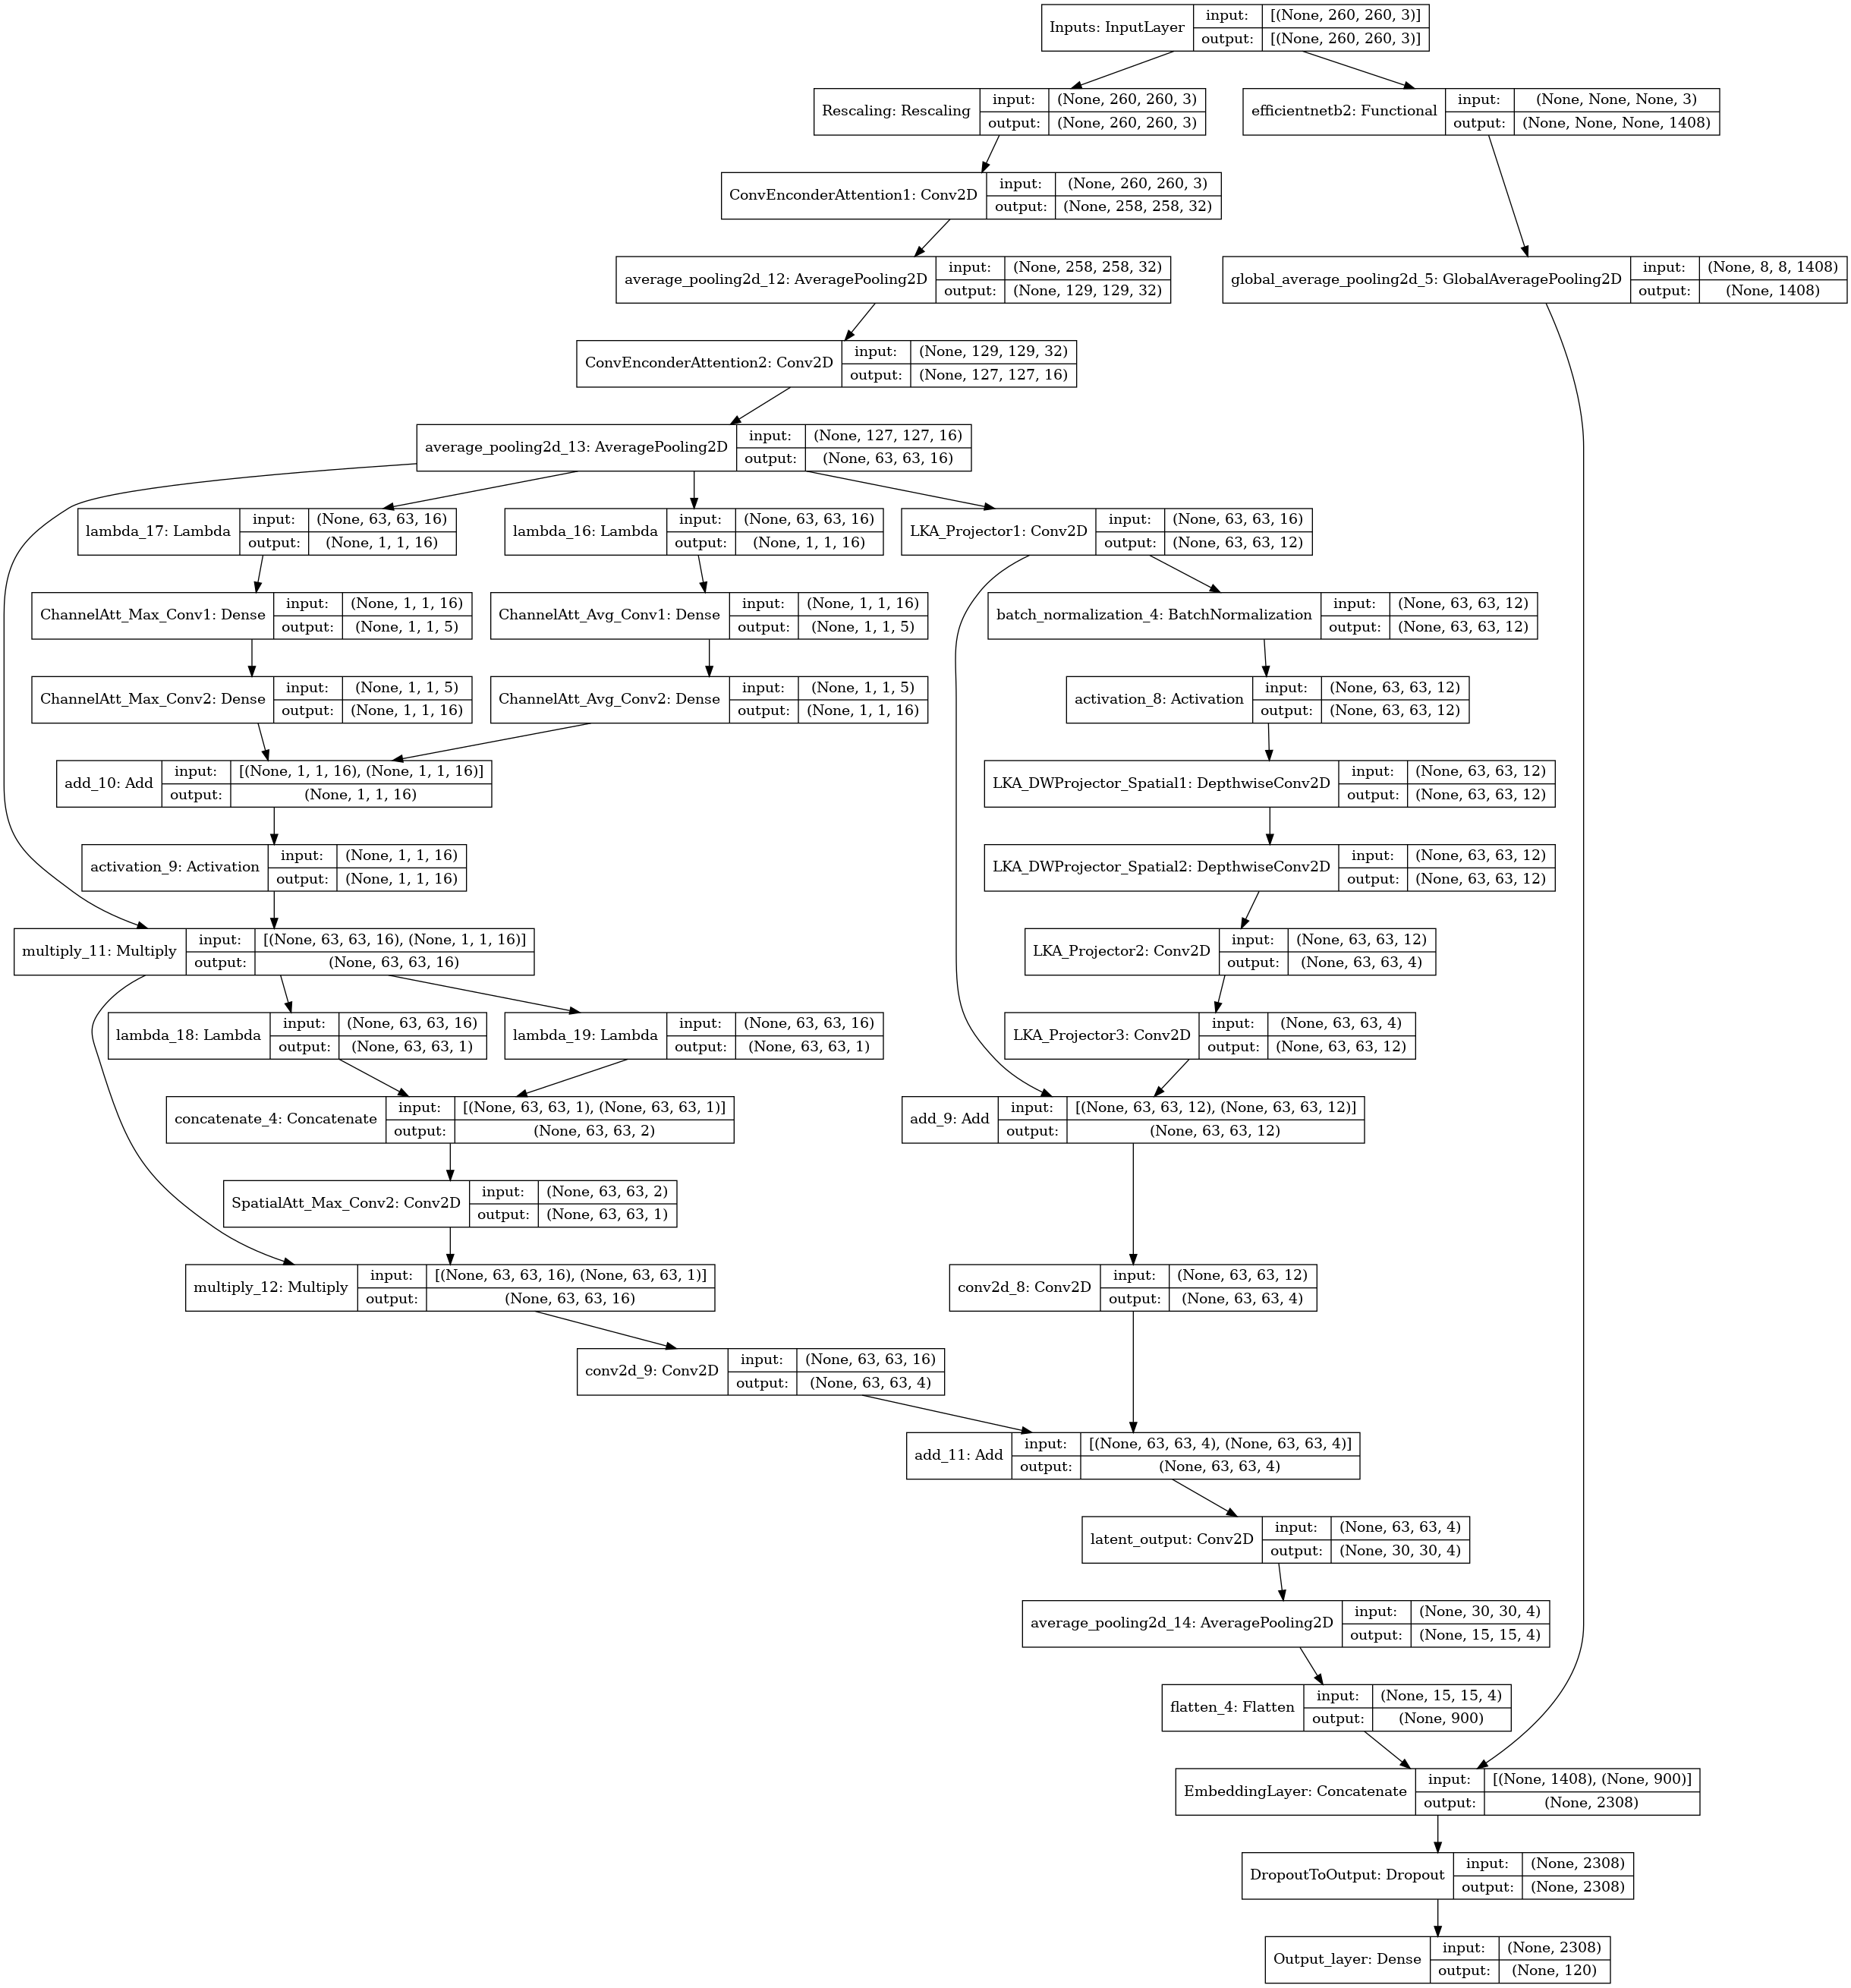

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True,to_file='FerNet.png')

In [26]:
# Set checkpoint path
checkpoint_path = "/pechpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         verbose=1,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch", monitor="val_accuracy")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.10,patience=4, verbose=1)

early_stopper = tf.keras.callbacks.EarlyStopping(patience=10, 
                                                 restore_best_weights=True,
                                                 monitor="val_accuracy")

initial_epochs = 15
FerNetHistory = model.fit(train_ds,
                           epochs=initial_epochs,
                           steps_per_epoch=len(train_ds),
                           validation_data = val_ds,
                           callbacks=[checkpoint_callback, reduce_lr, early_stopper])

Epoch 1/15
515/515 [==============================] - ETA: 0s - loss: 1.4190 - accuracy: 0.7704

Cleanup called...


515/515 [==============================] - 131s 210ms/step - loss: 1.4190 - accuracy: 0.7704 - val_loss: 0.6658 - val_accuracy: 0.8761

Epoch 00001: val_accuracy improved from -inf to 0.87609, saving model to /pechpoints_weights/checkpoint.ckpt
Epoch 2/15
515/515 [==============================] - ETA: 0s - loss: 0.6072 - accuracy: 0.8953

Cleanup called...


515/515 [==============================] - 101s 196ms/step - loss: 0.6072 - accuracy: 0.8953 - val_loss: 0.6168 - val_accuracy: 0.8836

Epoch 00002: val_accuracy improved from 0.87609 to 0.88362, saving model to /pechpoints_weights/checkpoint.ckpt
Epoch 3/15
515/515 [==============================] - ETA: 0s - loss: 0.5340 - accuracy: 0.9201

Cleanup called...


515/515 [==============================] - 101s 196ms/step - loss: 0.5340 - accuracy: 0.9201 - val_loss: 0.6097 - val_accuracy: 0.8882

Epoch 00003: val_accuracy improved from 0.88362 to 0.88824, saving model to /pechpoints_weights/checkpoint.ckpt
Epoch 4/15
515/515 [==============================] - ETA: 0s - loss: 0.4852 - accuracy: 0.9372

Cleanup called...


515/515 [==============================] - 102s 197ms/step - loss: 0.4852 - accuracy: 0.9372 - val_loss: 0.6115 - val_accuracy: 0.8863

Epoch 00004: val_accuracy did not improve from 0.88824
Epoch 5/15
515/515 [==============================] - ETA: 0s - loss: 0.4428 - accuracy: 0.9534

Cleanup called...


515/515 [==============================] - 104s 201ms/step - loss: 0.4428 - accuracy: 0.9534 - val_loss: 0.6198 - val_accuracy: 0.8788

Epoch 00005: val_accuracy did not improve from 0.88824
Epoch 6/15
515/515 [==============================] - ETA: 0s - loss: 0.4173 - accuracy: 0.9609

Cleanup called...


515/515 [==============================] - 103s 199ms/step - loss: 0.4173 - accuracy: 0.9609 - val_loss: 0.6745 - val_accuracy: 0.8688

Epoch 00006: val_accuracy did not improve from 0.88824
Epoch 7/15
515/515 [==============================] - ETA: 0s - loss: 0.4054 - accuracy: 0.9656

Cleanup called...


515/515 [==============================] - 102s 197ms/step - loss: 0.4054 - accuracy: 0.9656 - val_loss: 0.6422 - val_accuracy: 0.8766

Epoch 00007: val_accuracy did not improve from 0.88824

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 8/15
515/515 [==============================] - ETA: 0s - loss: 0.3892 - accuracy: 0.9721

Cleanup called...


515/515 [==============================] - 104s 200ms/step - loss: 0.3892 - accuracy: 0.9721 - val_loss: 0.6217 - val_accuracy: 0.8836

Epoch 00008: val_accuracy did not improve from 0.88824
Epoch 9/15
515/515 [==============================] - ETA: 0s - loss: 0.3807 - accuracy: 0.9752

Cleanup called...


515/515 [==============================] - 103s 199ms/step - loss: 0.3807 - accuracy: 0.9752 - val_loss: 0.6219 - val_accuracy: 0.8819

Epoch 00009: val_accuracy did not improve from 0.88824
Epoch 10/15
515/515 [==============================] - ETA: 0s - loss: 0.3776 - accuracy: 0.9764

Cleanup called...


515/515 [==============================] - 102s 198ms/step - loss: 0.3776 - accuracy: 0.9764 - val_loss: 0.6208 - val_accuracy: 0.8856

Epoch 00010: val_accuracy did not improve from 0.88824
Epoch 11/15
515/515 [==============================] - ETA: 0s - loss: 0.3728 - accuracy: 0.9788

Cleanup called...


515/515 [==============================] - 103s 199ms/step - loss: 0.3728 - accuracy: 0.9788 - val_loss: 0.6231 - val_accuracy: 0.8831

Epoch 00011: val_accuracy did not improve from 0.88824

Epoch 00011: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 12/15
515/515 [==============================] - ETA: 0s - loss: 0.3697 - accuracy: 0.9793

Cleanup called...


515/515 [==============================] - 103s 199ms/step - loss: 0.3697 - accuracy: 0.9793 - val_loss: 0.6217 - val_accuracy: 0.8841

Epoch 00012: val_accuracy did not improve from 0.88824
Epoch 13/15
515/515 [==============================] - ETA: 0s - loss: 0.3671 - accuracy: 0.9804

Cleanup called...


515/515 [==============================] - 102s 198ms/step - loss: 0.3671 - accuracy: 0.9804 - val_loss: 0.6199 - val_accuracy: 0.8841

Epoch 00013: val_accuracy did not improve from 0.88824


### FerNet Fine tuning (last 10% layers)

In [27]:
model.load_weights(checkpoint_path) # Load best weights

# Reinstantiate Callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,patience=4, verbose=1)
early_stopper = tf.keras.callbacks.EarlyStopping(patience=10, 
                                                 restore_best_weights=True,
                                                 monitor="val_accuracy")
with strategy.scope():
    # Unfreeze all of the layer in the base model
    base_model.trainable = True
    
    to_unfreeze = round(len(base_model.layers)*0.10)
    print(f"Trainable layers of our base model: {to_unfreeze}\n")
    # Refreeze every layer except the last 10%
    for layer in base_model.layers[:-to_unfreeze]:
        layer.trainable = False
    
    # Recompile model
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                    optimizer= tf.keras.optimizers.Adam(FerNetHistory.history['lr'][-1]*.1),
                    metrics=["accuracy"])

    fine_tune_epochs = initial_epochs+15

    FerNet_fine_tuned = model.fit(train_ds,
                                  epochs=fine_tune_epochs,
                                  initial_epoch= FerNetHistory.epoch[-1]+1,
                                  validation_data = val_ds,
                                  callbacks=[checkpoint_callback, reduce_lr, early_stopper])

Trainable layers of our base model: 34

Epoch 14/30
515/515 [==============================] - ETA: 0s - loss: 0.2367 - accuracy: 0.9390

Cleanup called...


515/515 [==============================] - 140s 228ms/step - loss: 0.2367 - accuracy: 0.9390 - val_loss: 0.3669 - val_accuracy: 0.8912

Epoch 00014: val_accuracy improved from 0.88824 to 0.89116, saving model to /pechpoints_weights/checkpoint.ckpt
Epoch 15/30
515/515 [==============================] - ETA: 0s - loss: 0.2192 - accuracy: 0.9399

Cleanup called...


515/515 [==============================] - 117s 226ms/step - loss: 0.2192 - accuracy: 0.9399 - val_loss: 0.3585 - val_accuracy: 0.8914

Epoch 00015: val_accuracy improved from 0.89116 to 0.89140, saving model to /pechpoints_weights/checkpoint.ckpt
Epoch 16/30
515/515 [==============================] - ETA: 0s - loss: 0.2091 - accuracy: 0.9421

Cleanup called...


515/515 [==============================] - 110s 212ms/step - loss: 0.2091 - accuracy: 0.9421 - val_loss: 0.3536 - val_accuracy: 0.8921

Epoch 00016: val_accuracy improved from 0.89140 to 0.89213, saving model to /pechpoints_weights/checkpoint.ckpt
Epoch 17/30
515/515 [==============================] - ETA: 0s - loss: 0.2039 - accuracy: 0.9412

Cleanup called...


515/515 [==============================] - 110s 213ms/step - loss: 0.2039 - accuracy: 0.9412 - val_loss: 0.3508 - val_accuracy: 0.8929

Epoch 00017: val_accuracy improved from 0.89213 to 0.89286, saving model to /pechpoints_weights/checkpoint.ckpt
Epoch 18/30
515/515 [==============================] - ETA: 0s - loss: 0.1971 - accuracy: 0.9431

Cleanup called...


515/515 [==============================] - 111s 214ms/step - loss: 0.1971 - accuracy: 0.9431 - val_loss: 0.3490 - val_accuracy: 0.8931

Epoch 00018: val_accuracy improved from 0.89286 to 0.89310, saving model to /pechpoints_weights/checkpoint.ckpt
Epoch 19/30
515/515 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.9423

Cleanup called...


515/515 [==============================] - 117s 226ms/step - loss: 0.1938 - accuracy: 0.9423 - val_loss: 0.3476 - val_accuracy: 0.8941

Epoch 00019: val_accuracy improved from 0.89310 to 0.89407, saving model to /pechpoints_weights/checkpoint.ckpt
Epoch 20/30
515/515 [==============================] - ETA: 0s - loss: 0.1906 - accuracy: 0.9425

Cleanup called...


515/515 [==============================] - 111s 214ms/step - loss: 0.1906 - accuracy: 0.9425 - val_loss: 0.3468 - val_accuracy: 0.8943

Epoch 00020: val_accuracy improved from 0.89407 to 0.89431, saving model to /pechpoints_weights/checkpoint.ckpt
Epoch 21/30
515/515 [==============================] - ETA: 0s - loss: 0.1888 - accuracy: 0.9436

Cleanup called...


515/515 [==============================] - 110s 212ms/step - loss: 0.1888 - accuracy: 0.9436 - val_loss: 0.3462 - val_accuracy: 0.8950

Epoch 00021: val_accuracy improved from 0.89431 to 0.89504, saving model to /pechpoints_weights/checkpoint.ckpt
Epoch 22/30
515/515 [==============================] - ETA: 0s - loss: 0.1827 - accuracy: 0.9470

Cleanup called...


515/515 [==============================] - 110s 213ms/step - loss: 0.1827 - accuracy: 0.9470 - val_loss: 0.3458 - val_accuracy: 0.8948

Epoch 00022: val_accuracy did not improve from 0.89504
Epoch 23/30
515/515 [==============================] - ETA: 0s - loss: 0.1799 - accuracy: 0.9457

Cleanup called...


515/515 [==============================] - 111s 214ms/step - loss: 0.1799 - accuracy: 0.9457 - val_loss: 0.3453 - val_accuracy: 0.8938

Epoch 00023: val_accuracy did not improve from 0.89504
Epoch 24/30
515/515 [==============================] - ETA: 0s - loss: 0.1737 - accuracy: 0.9488

Cleanup called...


515/515 [==============================] - 111s 214ms/step - loss: 0.1737 - accuracy: 0.9488 - val_loss: 0.3449 - val_accuracy: 0.8941

Epoch 00024: val_accuracy did not improve from 0.89504
Epoch 25/30
515/515 [==============================] - ETA: 0s - loss: 0.1757 - accuracy: 0.9459

Cleanup called...


515/515 [==============================] - 110s 212ms/step - loss: 0.1757 - accuracy: 0.9459 - val_loss: 0.3448 - val_accuracy: 0.8938

Epoch 00025: val_accuracy did not improve from 0.89504

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-07.
Epoch 26/30
515/515 [==============================] - ETA: 0s - loss: 0.1755 - accuracy: 0.9473

Cleanup called...


515/515 [==============================] - 111s 214ms/step - loss: 0.1755 - accuracy: 0.9473 - val_loss: 0.3448 - val_accuracy: 0.8941

Epoch 00026: val_accuracy did not improve from 0.89504
Epoch 27/30
515/515 [==============================] - ETA: 0s - loss: 0.1739 - accuracy: 0.9467

Cleanup called...


515/515 [==============================] - 110s 213ms/step - loss: 0.1739 - accuracy: 0.9467 - val_loss: 0.3448 - val_accuracy: 0.8938

Epoch 00027: val_accuracy did not improve from 0.89504
Epoch 28/30
515/515 [==============================] - ETA: 0s - loss: 0.1737 - accuracy: 0.9475

Cleanup called...


515/515 [==============================] - 110s 213ms/step - loss: 0.1737 - accuracy: 0.9475 - val_loss: 0.3448 - val_accuracy: 0.8938

Epoch 00028: val_accuracy did not improve from 0.89504
Epoch 29/30
515/515 [==============================] - ETA: 0s - loss: 0.1725 - accuracy: 0.9473

Cleanup called...


515/515 [==============================] - 109s 211ms/step - loss: 0.1725 - accuracy: 0.9473 - val_loss: 0.3447 - val_accuracy: 0.8936

Epoch 00029: val_accuracy did not improve from 0.89504

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.0000000656873454e-08.
Epoch 30/30
515/515 [==============================] - ETA: 0s - loss: 0.1753 - accuracy: 0.9460

Cleanup called...


515/515 [==============================] - 110s 213ms/step - loss: 0.1753 - accuracy: 0.9460 - val_loss: 0.3447 - val_accuracy: 0.8936

Epoch 00030: val_accuracy did not improve from 0.89504


### Save our best model

In [28]:
# load best weights
model.load_weights(checkpoint_path)
# Save model and load
model.save("FerNet_EfficientNetB2")
FerNetEffNetB2_Loaded = tf.keras.models.load_model("FerNet_EfficientNetB2")
!zip -r FerNet_EfficientNet.zip FerNet_EfficientNetB2

2022-12-19 00:13:18.456259: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


updating: FerNet_EfficientNetB2/ (stored 0%)
updating: FerNet_EfficientNetB2/assets/ (stored 0%)
updating: FerNet_EfficientNetB2/keras_metadata.pb (deflated 96%)
updating: FerNet_EfficientNetB2/saved_model.pb (deflated 91%)
updating: FerNet_EfficientNetB2/variables/ (stored 0%)
updating: FerNet_EfficientNetB2/variables/variables.data-00000-of-00001 (deflated 8%)
updating: FerNet_EfficientNetB2/variables/variables.index (deflated 76%)


In [29]:
print(f"Best Model Validation Accuracy: {FerNetEffNetB2_Loaded.evaluate(val_ds, verbose=0)[1]}")

Cleanup called...


Best Model Validation Accuracy: 0.8950437307357788


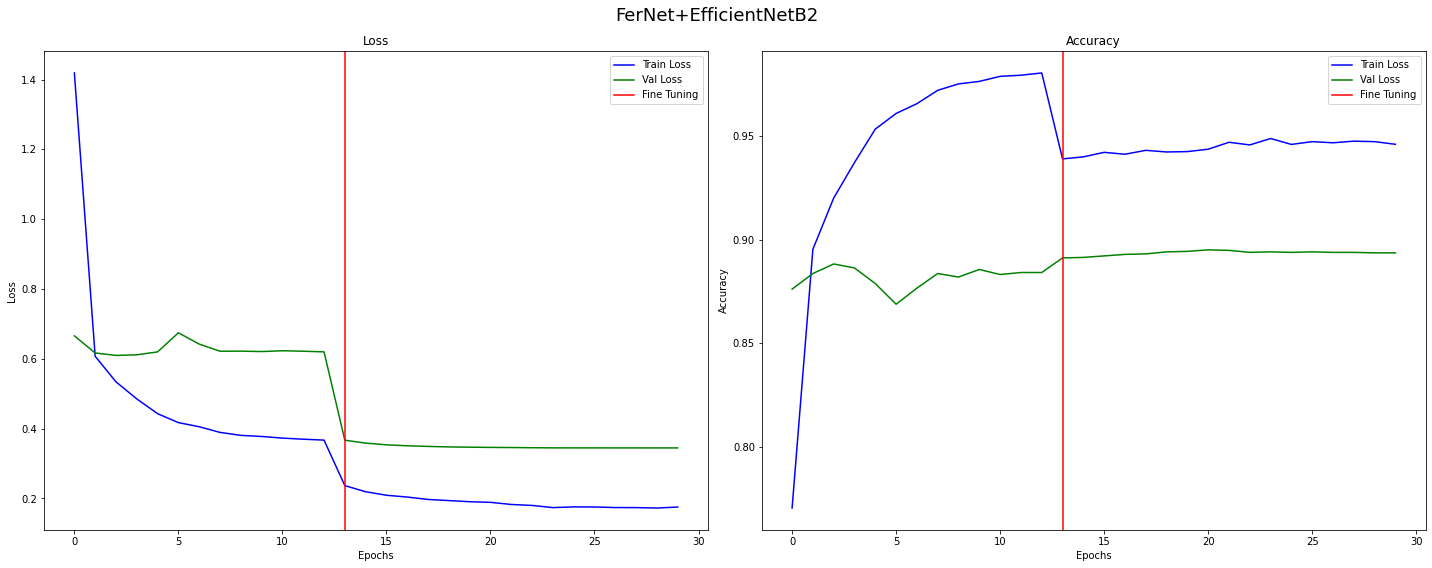

In [30]:
plotModelsCurves(FerNetHistory, FerNet_fine_tuned, model_name="FerNet+EfficientNetB2")

## EfficientNetB2 Alone

In [5]:
with strategy.scope():
    base_model = tf.keras.applications.EfficientNetB2(include_top=False)
    base_model.trainable = False
    input_shape = IMG_SIZE+(3,)
    
    inputs = tf.keras.layers.Input(shape=input_shape, name="Input_layer")
    ## EfficientNetB2
    effNet_model = base_model(inputs, training=False)
    effNet_model = tf.keras.layers.GlobalAveragePooling2D()(effNet_model)
    effNet_model = tf.keras.layers.Dropout(rate=0.5,name="Dropout2")(effNet_model)
    outputs = tf.keras.layers.Dense(num_outputs, activation=tf.nn.softmax, name="Output_layer")(effNet_model)
    # Create model
    effb2 = tf.keras.Model(inputs=inputs, outputs=outputs)
    # Compile model
    effb2.compile(loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.025),
                  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=["accuracy"])
    effb2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 260, 260, 3)]     0         
_________________________________________________________________
efficientnetb2 (Functional)  (None, None, None, 1408)  7768569   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1408)              0         
_________________________________________________________________
Dropout2 (Dropout)           (None, 1408)              0         
_________________________________________________________________
Output_layer (Dense)         (None, 120)               169080    
Total params: 7,937,649
Trainable params: 169,080
Non-trainable params: 7,768,569
_________________________________________________________________


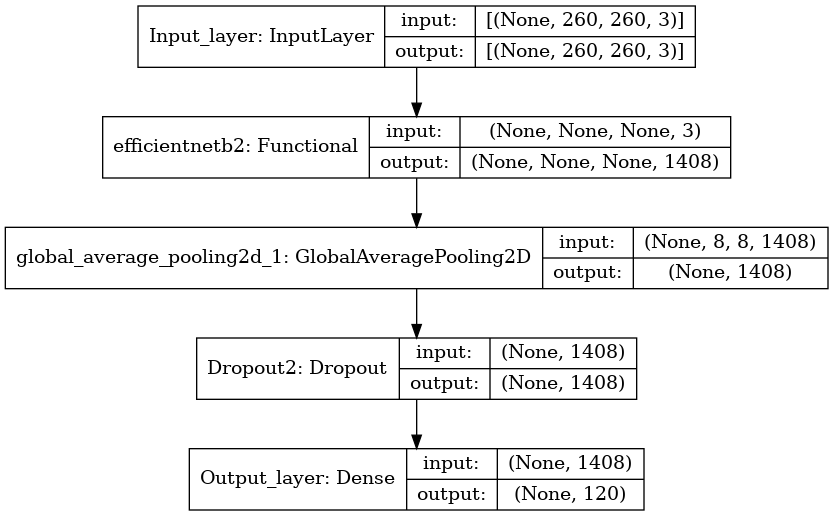

In [7]:
from tensorflow.keras.utils import plot_model
plot_model(effb2, show_shapes=True)

In [8]:
# Set checkpoint path
checkpoint_path = "/pechpoints_weights/checkpoint_effnetb2.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         verbose=1,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch", monitor="val_accuracy")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.10,patience=4, verbose=1)

early_stopper = tf.keras.callbacks.EarlyStopping(patience=10, 
                                                 restore_best_weights=True,
                                                 monitor="val_accuracy")
initial_epochs = 15
effb2History = effb2.fit(train_ds,
                           epochs=initial_epochs,
                           steps_per_epoch=len(train_ds),
                           validation_data = val_ds,
                           callbacks=[checkpoint_callback, reduce_lr, early_stopper])

2022-12-18 22:16:00.630080: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-12-18 22:16:20.859564: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-12-18 22:16:21.320209: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


515/515 [==============================] - ETA: 0s - loss: 1.4445 - accuracy: 0.7574

Cleanup called...


515/515 [==============================] - 164s 258ms/step - loss: 1.4445 - accuracy: 0.7574 - val_loss: 0.6691 - val_accuracy: 0.8790

Epoch 00001: val_accuracy improved from -inf to 0.87901, saving model to /pechpoints_weights/checkpoint_effnetb2.ckpt
Epoch 2/15
514/515 [============================>.] - ETA: 0s - loss: 0.6140 - accuracy: 0.8907

Cleanup called...


515/515 [==============================] - 68s 131ms/step - loss: 0.6138 - accuracy: 0.8907 - val_loss: 0.6167 - val_accuracy: 0.8827

Epoch 00002: val_accuracy improved from 0.87901 to 0.88265, saving model to /pechpoints_weights/checkpoint_effnetb2.ckpt
Epoch 3/15
514/515 [============================>.] - ETA: 0s - loss: 0.5469 - accuracy: 0.9134

Cleanup called...


515/515 [==============================] - 68s 131ms/step - loss: 0.5467 - accuracy: 0.9134 - val_loss: 0.6078 - val_accuracy: 0.8819

Epoch 00003: val_accuracy did not improve from 0.88265
Epoch 4/15
514/515 [============================>.] - ETA: 0s - loss: 0.5083 - accuracy: 0.9252

Cleanup called...


515/515 [==============================] - 69s 134ms/step - loss: 0.5083 - accuracy: 0.9252 - val_loss: 0.6075 - val_accuracy: 0.8848

Epoch 00004: val_accuracy improved from 0.88265 to 0.88484, saving model to /pechpoints_weights/checkpoint_effnetb2.ckpt
Epoch 5/15
514/515 [============================>.] - ETA: 0s - loss: 0.4815 - accuracy: 0.9371

Cleanup called...


515/515 [==============================] - 68s 131ms/step - loss: 0.4813 - accuracy: 0.9372 - val_loss: 0.6058 - val_accuracy: 0.8870

Epoch 00005: val_accuracy improved from 0.88484 to 0.88703, saving model to /pechpoints_weights/checkpoint_effnetb2.ckpt
Epoch 6/15
514/515 [============================>.] - ETA: 0s - loss: 0.4581 - accuracy: 0.9427

Cleanup called...


515/515 [==============================] - 68s 131ms/step - loss: 0.4580 - accuracy: 0.9428 - val_loss: 0.6094 - val_accuracy: 0.8858

Epoch 00006: val_accuracy did not improve from 0.88703
Epoch 7/15
515/515 [==============================] - ETA: 0s - loss: 0.4419 - accuracy: 0.9513

Cleanup called...


515/515 [==============================] - 68s 130ms/step - loss: 0.4419 - accuracy: 0.9513 - val_loss: 0.6106 - val_accuracy: 0.8819

Epoch 00007: val_accuracy did not improve from 0.88703
Epoch 8/15
514/515 [============================>.] - ETA: 0s - loss: 0.4296 - accuracy: 0.9559

Cleanup called...


515/515 [==============================] - 69s 133ms/step - loss: 0.4297 - accuracy: 0.9558 - val_loss: 0.6109 - val_accuracy: 0.8856

Epoch 00008: val_accuracy did not improve from 0.88703
Epoch 9/15
514/515 [============================>.] - ETA: 0s - loss: 0.4186 - accuracy: 0.9601

Cleanup called...


515/515 [==============================] - 71s 136ms/step - loss: 0.4186 - accuracy: 0.9601 - val_loss: 0.6123 - val_accuracy: 0.8863

Epoch 00009: val_accuracy did not improve from 0.88703

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 10/15
514/515 [============================>.] - ETA: 0s - loss: 0.3971 - accuracy: 0.9689

Cleanup called...


515/515 [==============================] - 70s 135ms/step - loss: 0.3971 - accuracy: 0.9690 - val_loss: 0.6019 - val_accuracy: 0.8878

Epoch 00010: val_accuracy improved from 0.88703 to 0.88776, saving model to /pechpoints_weights/checkpoint_effnetb2.ckpt
Epoch 11/15
514/515 [============================>.] - ETA: 0s - loss: 0.3960 - accuracy: 0.9667

Cleanup called...


515/515 [==============================] - 67s 129ms/step - loss: 0.3959 - accuracy: 0.9667 - val_loss: 0.6001 - val_accuracy: 0.8882

Epoch 00011: val_accuracy improved from 0.88776 to 0.88824, saving model to /pechpoints_weights/checkpoint_effnetb2.ckpt
Epoch 12/15
514/515 [============================>.] - ETA: 0s - loss: 0.3930 - accuracy: 0.9692

Cleanup called...


515/515 [==============================] - 69s 133ms/step - loss: 0.3931 - accuracy: 0.9691 - val_loss: 0.6000 - val_accuracy: 0.8882

Epoch 00012: val_accuracy did not improve from 0.88824
Epoch 13/15
514/515 [============================>.] - ETA: 0s - loss: 0.3936 - accuracy: 0.9698

Cleanup called...


515/515 [==============================] - 70s 135ms/step - loss: 0.3936 - accuracy: 0.9698 - val_loss: 0.6003 - val_accuracy: 0.8882

Epoch 00013: val_accuracy did not improve from 0.88824
Epoch 14/15
514/515 [============================>.] - ETA: 0s - loss: 0.3909 - accuracy: 0.9691

Cleanup called...


515/515 [==============================] - 71s 137ms/step - loss: 0.3909 - accuracy: 0.9691 - val_loss: 0.5999 - val_accuracy: 0.8882

Epoch 00014: val_accuracy did not improve from 0.88824
Epoch 15/15
514/515 [============================>.] - ETA: 0s - loss: 0.3880 - accuracy: 0.9706

Cleanup called...


515/515 [==============================] - 67s 130ms/step - loss: 0.3880 - accuracy: 0.9705 - val_loss: 0.5991 - val_accuracy: 0.8878

Epoch 00015: val_accuracy did not improve from 0.88824

Epoch 00015: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


### Base Model Fine tuning (last 10% layers)

In [11]:
effb2.load_weights(checkpoint_path) # Load best weights

# Reinstantiate Callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,patience=4, verbose=1)
early_stopper = tf.keras.callbacks.EarlyStopping(patience=5, 
                                                 restore_best_weights=True,
                                                 monitor="val_accuracy")
with strategy.scope():
    # Unfreeze all of the layer in the base model
    base_model.trainable = True
    
    to_unfreeze = round(len(base_model.layers)*0.10)
    print(f"Trainable layers of our base model: {to_unfreeze}\n")
    # Refreeze every layer except the last 10%
    for layer in base_model.layers[:-to_unfreeze]:
        layer.trainable = False
    
    # Recompile model
    effb2.compile(loss=tf.keras.losses.categorical_crossentropy,
                    optimizer= tf.keras.optimizers.Adam(effb2History.history['lr'][-1]*.1),
                    metrics=["accuracy"])

    fine_tune_epochs = initial_epochs+15

    fine_tuned_effb2History = effb2.fit(train_ds,
                                  epochs=fine_tune_epochs,
                                  initial_epoch= effb2History.epoch[-1]+1,
                                  validation_data = val_ds,
                                  callbacks=[checkpoint_callback, reduce_lr, early_stopper])

Trainable layers of our base model: 34

Epoch 16/30
515/515 [==============================] - ETA: 0s - loss: 0.1182 - accuracy: 0.9676

Cleanup called...


515/515 [==============================] - 99s 152ms/step - loss: 0.1182 - accuracy: 0.9676 - val_loss: 0.3658 - val_accuracy: 0.8878

Epoch 00016: val_accuracy did not improve from 0.88824
Epoch 17/30
515/515 [==============================] - ETA: 0s - loss: 0.1006 - accuracy: 0.9692

Cleanup called...


515/515 [==============================] - 73s 142ms/step - loss: 0.1006 - accuracy: 0.9692 - val_loss: 0.3672 - val_accuracy: 0.8909

Epoch 00017: val_accuracy improved from 0.88824 to 0.89091, saving model to /pechpoints_weights/checkpoint_effnetb2.ckpt
Epoch 18/30
515/515 [==============================] - ETA: 0s - loss: 0.0929 - accuracy: 0.9710

Cleanup called...


515/515 [==============================] - 72s 140ms/step - loss: 0.0929 - accuracy: 0.9710 - val_loss: 0.3704 - val_accuracy: 0.8912

Epoch 00018: val_accuracy improved from 0.89091 to 0.89116, saving model to /pechpoints_weights/checkpoint_effnetb2.ckpt
Epoch 19/30
515/515 [==============================] - ETA: 0s - loss: 0.0851 - accuracy: 0.9744

Cleanup called...


515/515 [==============================] - 74s 142ms/step - loss: 0.0851 - accuracy: 0.9744 - val_loss: 0.3756 - val_accuracy: 0.8914

Epoch 00019: val_accuracy improved from 0.89116 to 0.89140, saving model to /pechpoints_weights/checkpoint_effnetb2.ckpt
Epoch 20/30
515/515 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.9750

Cleanup called...


515/515 [==============================] - 75s 144ms/step - loss: 0.0820 - accuracy: 0.9750 - val_loss: 0.3794 - val_accuracy: 0.8887

Epoch 00020: val_accuracy did not improve from 0.89140
Epoch 21/30
515/515 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.9766

Cleanup called...


515/515 [==============================] - 80s 154ms/step - loss: 0.0746 - accuracy: 0.9766 - val_loss: 0.3830 - val_accuracy: 0.8904

Epoch 00021: val_accuracy did not improve from 0.89140
Epoch 22/30
515/515 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.9793

Cleanup called...


515/515 [==============================] - 74s 142ms/step - loss: 0.0716 - accuracy: 0.9793 - val_loss: 0.3866 - val_accuracy: 0.8895

Epoch 00022: val_accuracy did not improve from 0.89140
Epoch 23/30
515/515 [==============================] - ETA: 0s - loss: 0.0636 - accuracy: 0.9813

Cleanup called...


515/515 [==============================] - 73s 141ms/step - loss: 0.0636 - accuracy: 0.9813 - val_loss: 0.3909 - val_accuracy: 0.8887

Epoch 00023: val_accuracy did not improve from 0.89140

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.0000000474974515e-06.
Epoch 24/30
515/515 [==============================] - ETA: 0s - loss: 0.0573 - accuracy: 0.9838

Cleanup called...


515/515 [==============================] - 73s 141ms/step - loss: 0.0573 - accuracy: 0.9838 - val_loss: 0.3913 - val_accuracy: 0.8907

Epoch 00024: val_accuracy did not improve from 0.89140


In [33]:
# load best weights
effb2.load_weights("/pechpoints_weights/checkpoint_effnetb2.ckpt")
# Save model and load
effb2.save("EfficientNetB2")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [32]:
print(f"Best Model Validation Accuracy: {effb2.evaluate(val_ds, verbose=0)[1]}")

Cleanup called...


Best Model Validation Accuracy: 0.8913994431495667


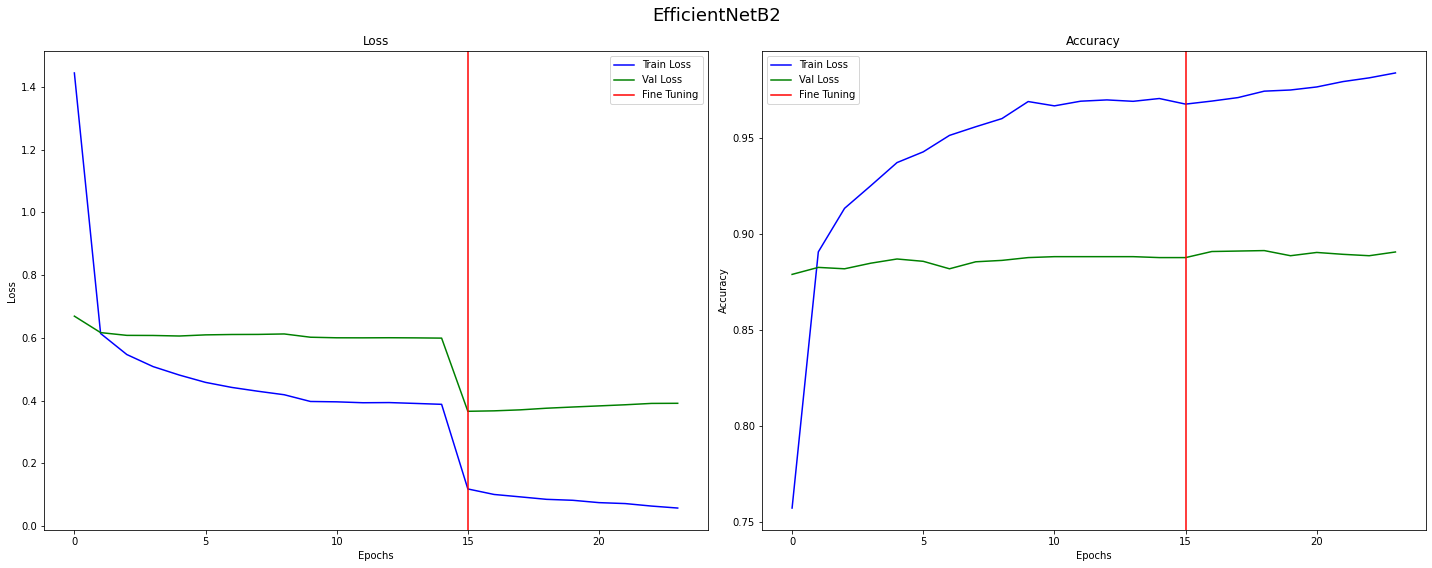

In [34]:
plotModelsCurves(effb2History, fine_tuned_effb2History, model_name="EfficientNetB2")

## Only LKA on Latent

In [38]:
# fix random seed for reproducibility
#tf.random.set_seed(0)
with strategy.scope():
    
    base_model = tf.keras.applications.EfficientNetB2(include_top=False)
    base_model.trainable = False
    input_shape = IMG_SIZE+(3,)
    
    inputs = tf.keras.layers.Input(shape=input_shape, name="Inputs")

    ## EfficientNet
    effNet_model = base_model(inputs, training=False)
    
    effNet_model = tf.keras.layers.GlobalAveragePooling2D()(effNet_model)
    eff_model = tf.keras.Model(inputs=inputs, outputs=effNet_model, name="EfficientNetB2")

    ## Visual Attention
    va = tf.keras.layers.Rescaling(1/255., name="Rescaling")(inputs)
    
    va = tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.gelu, strides=1, name="ConvEnconderAttention1")(va)
    va = tf.keras.layers.AveragePooling2D()(va)
    va = tf.keras.layers.Conv2D(16, 3, activation=tf.keras.activations.gelu, strides=1, name="ConvEnconderAttention2")(va)
    va = tf.keras.layers.AveragePooling2D()(va)
    
    # LKA    
    va_input = tf.keras.layers.Conv2D(12, 1, name='LKA_Projector1')(va)
    va1 = tf.keras.layers.BatchNormalization()(va_input)
    va1 = tf.keras.layers.Activation(tf.keras.activations.gelu)(va1)
    va1 = tf.keras.layers.DepthwiseConv2D(5, padding='same',name='LKA_DWProjector_Spatial1')(va1)
    va1 = tf.keras.layers.DepthwiseConv2D(7, padding='same', dilation_rate=3, name='LKA_DWProjector_Spatial2')(va1)
    va1 = tf.keras.layers.Conv2D(4, 1, name='LKA_Projector2')(va1)
    va1 = tf.keras.layers.Conv2D(12, 1, name='LKA_Projector3')(va1)
    va1 = tf.keras.layers.Add()([va1, va_input])

    va = tf.keras.layers.AveragePooling2D()(va)
    
    va_pooling = tf.keras.layers.Flatten()(va)   
    
    # Create module
    va_model = tf.keras.Model(inputs=inputs, outputs=va_pooling)

    # Concatenate with base model
    embedded_model = tf.keras.layers.Concatenate(name="EmbeddingLayer")([eff_model.output, va_model.output])
    #embedded_model = tf.keras.layers.Dense(512, activation="relu")(embedded_model)
    embedded_model = tf.keras.layers.Dropout(rate=0.5,name="DropoutToOutput")(embedded_model)
    outputs = tf.keras.layers.Dense(num_outputs, activation="softmax", name="Output_layer")(embedded_model)

    model_LKA_Only = tf.keras.Model(inputs=inputs, outputs=outputs, name="FerNet")

    model_LKA_Only.compile(loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.025),
                  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=["accuracy"])

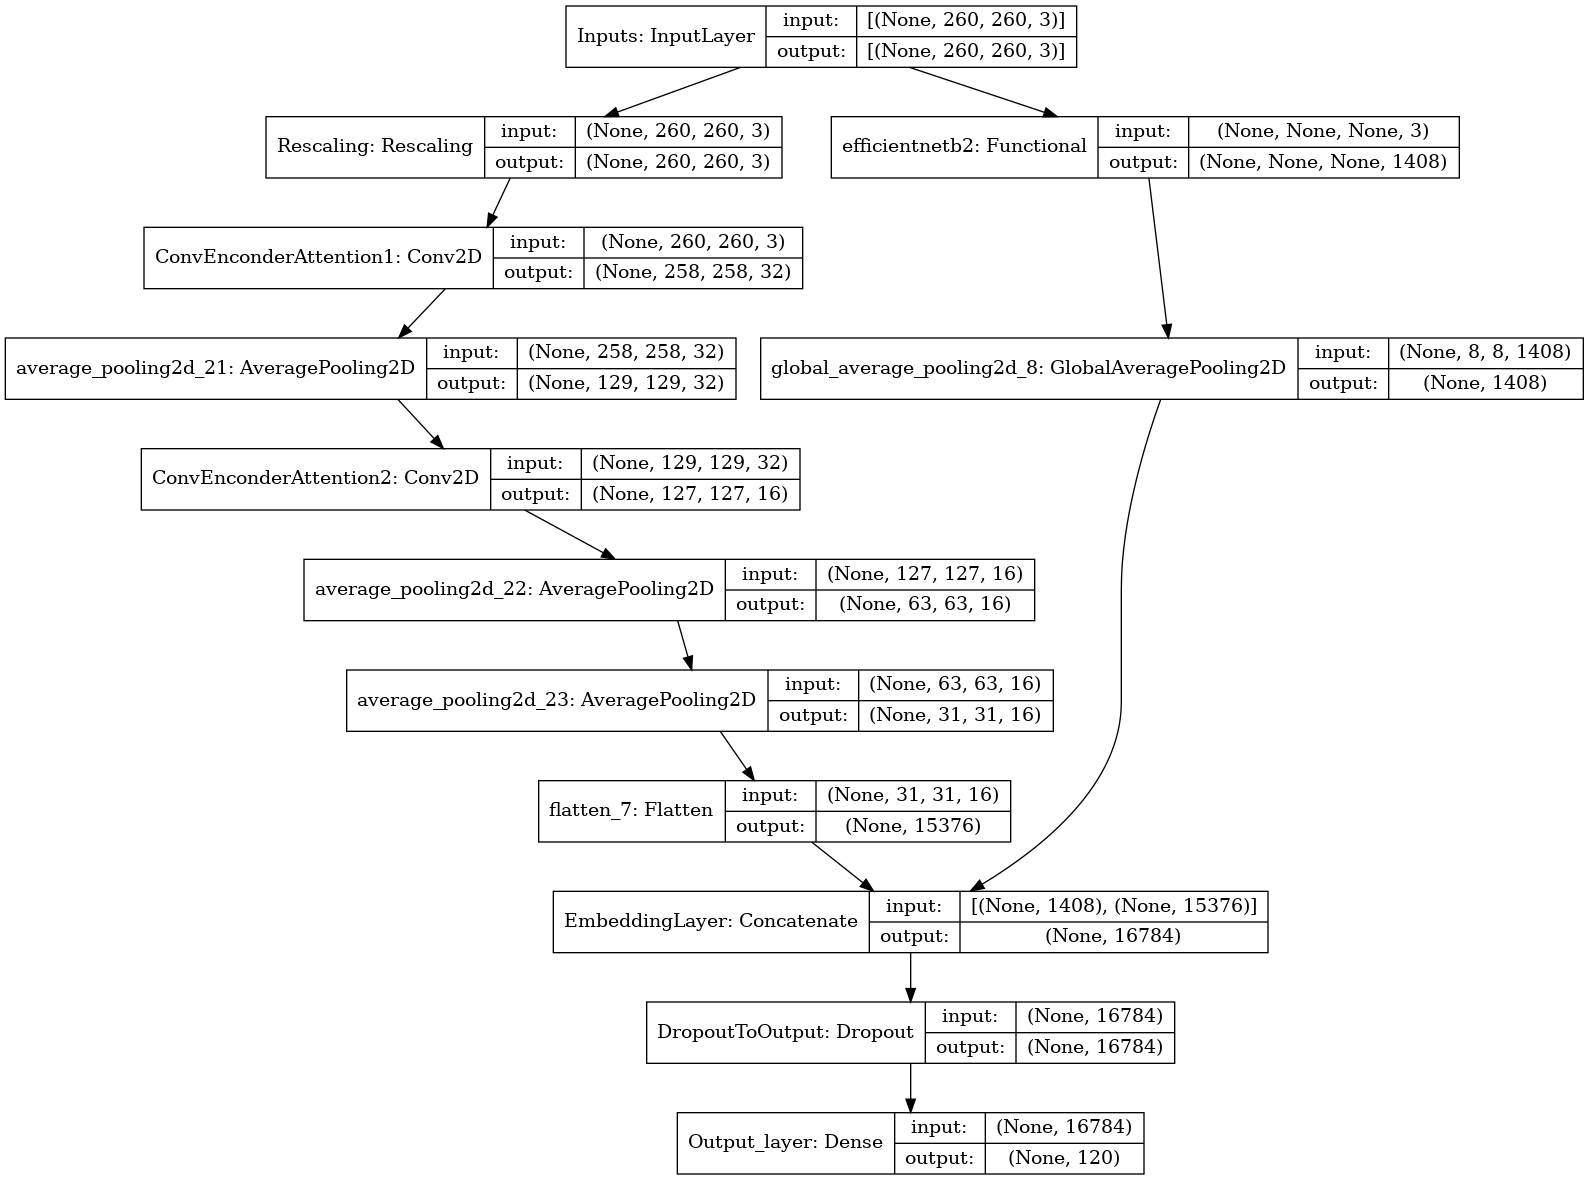

In [39]:
from tensorflow.keras.utils import plot_model
plot_model(model_LKA_Only, show_shapes=True)

In [40]:
# Set checkpoint path
checkpoint_path = "/pechpoints_weights/checkpoint_lka.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         verbose=1,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch", monitor="val_accuracy")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.10,patience=4, verbose=1)

early_stopper = tf.keras.callbacks.EarlyStopping(patience=6, 
                                                 restore_best_weights=True,
                                                 monitor="val_accuracy")
initial_epochs = 15
LKAHistory = model_LKA_Only.fit(train_ds,
                                   epochs=initial_epochs,
                                   steps_per_epoch=len(train_ds),
                                   validation_data = val_ds,
                                   callbacks=[checkpoint_callback, reduce_lr, early_stopper])

Epoch 1/15
515/515 [==============================] - ETA: 0s - loss: 1.3983 - accuracy: 0.7826

Cleanup called...


515/515 [==============================] - 112s 184ms/step - loss: 1.3983 - accuracy: 0.7826 - val_loss: 0.6734 - val_accuracy: 0.8729

Epoch 00001: val_accuracy improved from -inf to 0.87293, saving model to /pechpoints_weights/checkpoint_lka.ckpt
Epoch 2/15
515/515 [==============================] - ETA: 0s - loss: 0.5919 - accuracy: 0.9002

Cleanup called...


515/515 [==============================] - 85s 164ms/step - loss: 0.5919 - accuracy: 0.9002 - val_loss: 0.6301 - val_accuracy: 0.8751

Epoch 00002: val_accuracy improved from 0.87293 to 0.87512, saving model to /pechpoints_weights/checkpoint_lka.ckpt
Epoch 3/15
515/515 [==============================] - ETA: 0s - loss: 0.5110 - accuracy: 0.9272

Cleanup called...


515/515 [==============================] - 86s 166ms/step - loss: 0.5110 - accuracy: 0.9272 - val_loss: 0.6466 - val_accuracy: 0.8661

Epoch 00003: val_accuracy did not improve from 0.87512
Epoch 4/15
515/515 [==============================] - ETA: 0s - loss: 0.4467 - accuracy: 0.9542

Cleanup called...


515/515 [==============================] - 84s 163ms/step - loss: 0.4467 - accuracy: 0.9542 - val_loss: 0.6716 - val_accuracy: 0.8581

Epoch 00004: val_accuracy did not improve from 0.87512
Epoch 5/15
515/515 [==============================] - ETA: 0s - loss: 0.4037 - accuracy: 0.9682

Cleanup called...


515/515 [==============================] - 85s 163ms/step - loss: 0.4037 - accuracy: 0.9682 - val_loss: 0.6693 - val_accuracy: 0.8661

Epoch 00005: val_accuracy did not improve from 0.87512
Epoch 6/15
515/515 [==============================] - ETA: 0s - loss: 0.3621 - accuracy: 0.9851

Cleanup called...


515/515 [==============================] - 86s 165ms/step - loss: 0.3621 - accuracy: 0.9851 - val_loss: 0.6712 - val_accuracy: 0.8605

Epoch 00006: val_accuracy did not improve from 0.87512

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/15
515/515 [==============================] - ETA: 0s - loss: 0.3422 - accuracy: 0.9908

Cleanup called...


515/515 [==============================] - 85s 165ms/step - loss: 0.3422 - accuracy: 0.9908 - val_loss: 0.6503 - val_accuracy: 0.8659

Epoch 00007: val_accuracy did not improve from 0.87512
Epoch 8/15
515/515 [==============================] - ETA: 0s - loss: 0.3277 - accuracy: 0.9940

Cleanup called...


515/515 [==============================] - 85s 163ms/step - loss: 0.3277 - accuracy: 0.9940 - val_loss: 0.6542 - val_accuracy: 0.8676

Epoch 00008: val_accuracy did not improve from 0.87512


### LKA Fine tuning (last 10% layers)

In [41]:
model_LKA_Only.load_weights(checkpoint_path) # Load best weights

# Reinstantiate Callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,patience=4, verbose=1)
early_stopper = tf.keras.callbacks.EarlyStopping(patience=5, 
                                                 restore_best_weights=True,
                                                 monitor="val_accuracy")
with strategy.scope():
    # Unfreeze all of the layer in the base model
    base_model.trainable = True
    
    to_unfreeze = round(len(base_model.layers)*0.10)
    print(f"Trainable layers of our base model: {to_unfreeze}\n")
    # Refreeze every layer except the last 10%
    for layer in base_model.layers[:-to_unfreeze]:
        layer.trainable = False
    
    # Recompile model 
    model_LKA_Only.compile(loss=tf.keras.losses.categorical_crossentropy,
                    optimizer= tf.keras.optimizers.Adam(LKAHistory.history['lr'][-1]*.1),
                    metrics=["accuracy"])

    fine_tune_epochs = initial_epochs+15

    fine_tuned_LKAHistory = model_LKA_Only.fit(train_ds,
                                                  epochs=fine_tune_epochs,
                                                  initial_epoch= LKAHistory.epoch[-1]+1,
                                                  validation_data = val_ds,
                                                  callbacks=[checkpoint_callback, reduce_lr, early_stopper])

Trainable layers of our base model: 34

Epoch 9/30
515/515 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.9319

Cleanup called...


515/515 [==============================] - 117s 191ms/step - loss: 0.2342 - accuracy: 0.9319 - val_loss: 0.3548 - val_accuracy: 0.8882

Epoch 00009: val_accuracy improved from 0.87512 to 0.88824, saving model to /pechpoints_weights/checkpoint_lka.ckpt
Epoch 10/30
515/515 [==============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.9387

Cleanup called...


515/515 [==============================] - 93s 180ms/step - loss: 0.1984 - accuracy: 0.9387 - val_loss: 0.3505 - val_accuracy: 0.8878

Epoch 00010: val_accuracy did not improve from 0.88824
Epoch 11/30
515/515 [==============================] - ETA: 0s - loss: 0.1736 - accuracy: 0.9473

Cleanup called...


515/515 [==============================] - 94s 181ms/step - loss: 0.1736 - accuracy: 0.9473 - val_loss: 0.3501 - val_accuracy: 0.8865

Epoch 00011: val_accuracy did not improve from 0.88824
Epoch 12/30
515/515 [==============================] - ETA: 0s - loss: 0.1619 - accuracy: 0.9488

Cleanup called...


515/515 [==============================] - 95s 183ms/step - loss: 0.1619 - accuracy: 0.9488 - val_loss: 0.3508 - val_accuracy: 0.8848

Epoch 00012: val_accuracy did not improve from 0.88824
Epoch 13/30
515/515 [==============================] - ETA: 0s - loss: 0.1454 - accuracy: 0.9569

Cleanup called...


515/515 [==============================] - 94s 182ms/step - loss: 0.1454 - accuracy: 0.9569 - val_loss: 0.3530 - val_accuracy: 0.8853

Epoch 00013: val_accuracy did not improve from 0.88824

Epoch 00013: ReduceLROnPlateau reducing learning rate to 1.0000000474974515e-06.
Epoch 14/30
515/515 [==============================] - ETA: 0s - loss: 0.1295 - accuracy: 0.9611

Cleanup called...


515/515 [==============================] - 94s 181ms/step - loss: 0.1295 - accuracy: 0.9611 - val_loss: 0.3531 - val_accuracy: 0.8863

Epoch 00014: val_accuracy did not improve from 0.88824


In [42]:
# load best weights
model_LKA_Only.load_weights(checkpoint_path)
# Save model and load
model_LKA_Only.save("OnlyLKA")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [43]:
print(f"Best Model Validation Accuracy: {model_LKA_Only.evaluate(val_ds, verbose=0)[1]}")

Cleanup called...


Best Model Validation Accuracy: 0.8882409930229187


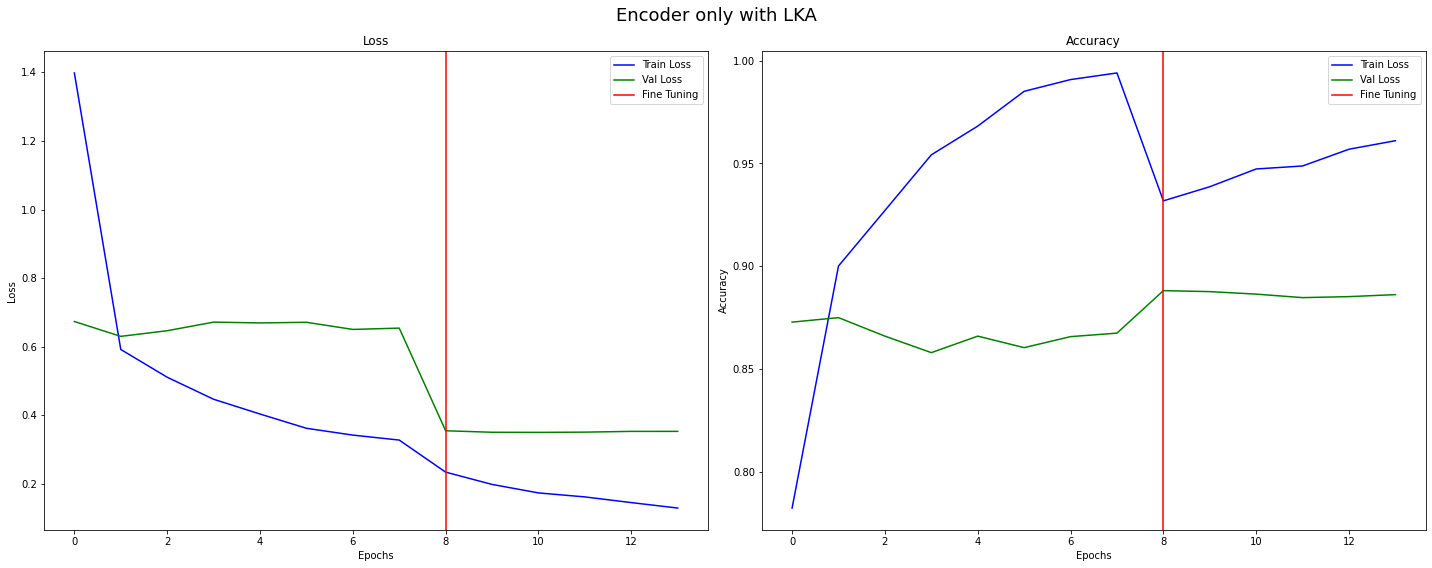

In [44]:
plotModelsCurves(LKAHistory, fine_tuned_LKAHistory, model_name="Encoder only with LKA")

## Only CBAM Block on Latent

In [49]:
# fix random seed for reproducibility
#tf.random.set_seed(0)
with strategy.scope():
    
    base_model = tf.keras.applications.EfficientNetB2(include_top=False)
    base_model.trainable = False
    input_shape = IMG_SIZE+(3,)
    
    inputs = tf.keras.layers.Input(shape=input_shape, name="Inputs")

    ## EfficientNet
    effNet_model = base_model(inputs, training=False)
    
    effNet_model = tf.keras.layers.GlobalAveragePooling2D()(effNet_model)
    eff_model = tf.keras.Model(inputs=inputs, outputs=effNet_model, name="EfficientNetB2")

    ## Visual Attention
    va = tf.keras.layers.Rescaling(1/255., name="Rescaling")(inputs)
    
    va = tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.gelu, strides=1, name="ConvEnconderAttention1")(va)
    va = tf.keras.layers.AveragePooling2D()(va)
    va = tf.keras.layers.Conv2D(16, 3, activation=tf.keras.activations.gelu, strides=1, name="ConvEnconderAttention2")(va)
    va = tf.keras.layers.AveragePooling2D()(va)
    
    # CBAM
    ## Channel Attention
    input_channels = va.get_shape()[-1]
    avg_pool_channel = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=[1,2], keepdims=True))(va)
    max_pool_channel = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=[1,2], keepdims=True))(va)
    avg_pool_channel = tf.keras.layers.Dense(input_channels//3,
                                             activation="relu", kernel_initializer='he_normal',
                                             use_bias=True,
                                             bias_initializer='zeros', name="ChannelAtt_Avg_Conv1")(avg_pool_channel)
    avg_pool_channel = tf.keras.layers.Dense(input_channels,
                                             kernel_initializer='he_normal',use_bias=True,
                                             bias_initializer='zeros', name="ChannelAtt_Avg_Conv2")(avg_pool_channel)
    max_pool_channel = tf.keras.layers.Dense(input_channels//3,
                                             activation="relu", kernel_initializer='he_normal',
                                             use_bias=True,
                                             bias_initializer='zeros', name="ChannelAtt_Max_Conv1")(max_pool_channel)
    max_pool_channel = tf.keras.layers.Dense(input_channels,
                                     kernel_initializer='he_normal',
                                     use_bias=True,
                                     bias_initializer='zeros', name="ChannelAtt_Max_Conv2")(max_pool_channel)
    channel_attention = tf.keras.layers.Add()([avg_pool_channel,max_pool_channel])
    channel_attention = tf.keras.layers.Activation("sigmoid")(channel_attention)
    channel_attention = tf.keras.layers.Multiply()([va, channel_attention])

    ## Spatial attention
    kernel_size = 7
    avg_pool_spatial = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(channel_attention)
    max_pool_spatial = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(channel_attention)
    
    spatial_attention = tf.keras.layers.Concatenate(axis=3)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = tf.keras.layers.Conv2D(filters = 1,
                                        kernel_size=kernel_size,
                                        strides=1,
                                        padding='same',
                                        activation= tf.keras.activations.sigmoid,
                                        kernel_initializer='he_normal',
                                        use_bias=False,name="SpatialAtt_Max_Conv2")(spatial_attention)
    spatial_attention = tf.keras.layers.multiply([channel_attention, spatial_attention])
    
    # Unify modules - Latent space
    va = tf.keras.layers.AveragePooling2D()(spatial_attention)
    
    va_pooling = tf.keras.layers.Flatten()(va)   
    
    # Create module
    va_model = tf.keras.Model(inputs=inputs, outputs=va_pooling)

    # Concatenate with base model
    embedded_model = tf.keras.layers.Concatenate(name="EmbeddingLayer")([eff_model.output, va_model.output])
    #embedded_model = tf.keras.layers.Dense(512, activation="relu")(embedded_model)
    embedded_model = tf.keras.layers.Dropout(rate=0.5,name="DropoutToOutput")(embedded_model)
    outputs = tf.keras.layers.Dense(num_outputs, activation="softmax", name="Output_layer")(embedded_model)

    model_CBAM_Only = tf.keras.Model(inputs=inputs, outputs=outputs, name="FerNet")

    model_CBAM_Only.compile(loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.025),
                  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=["accuracy"])

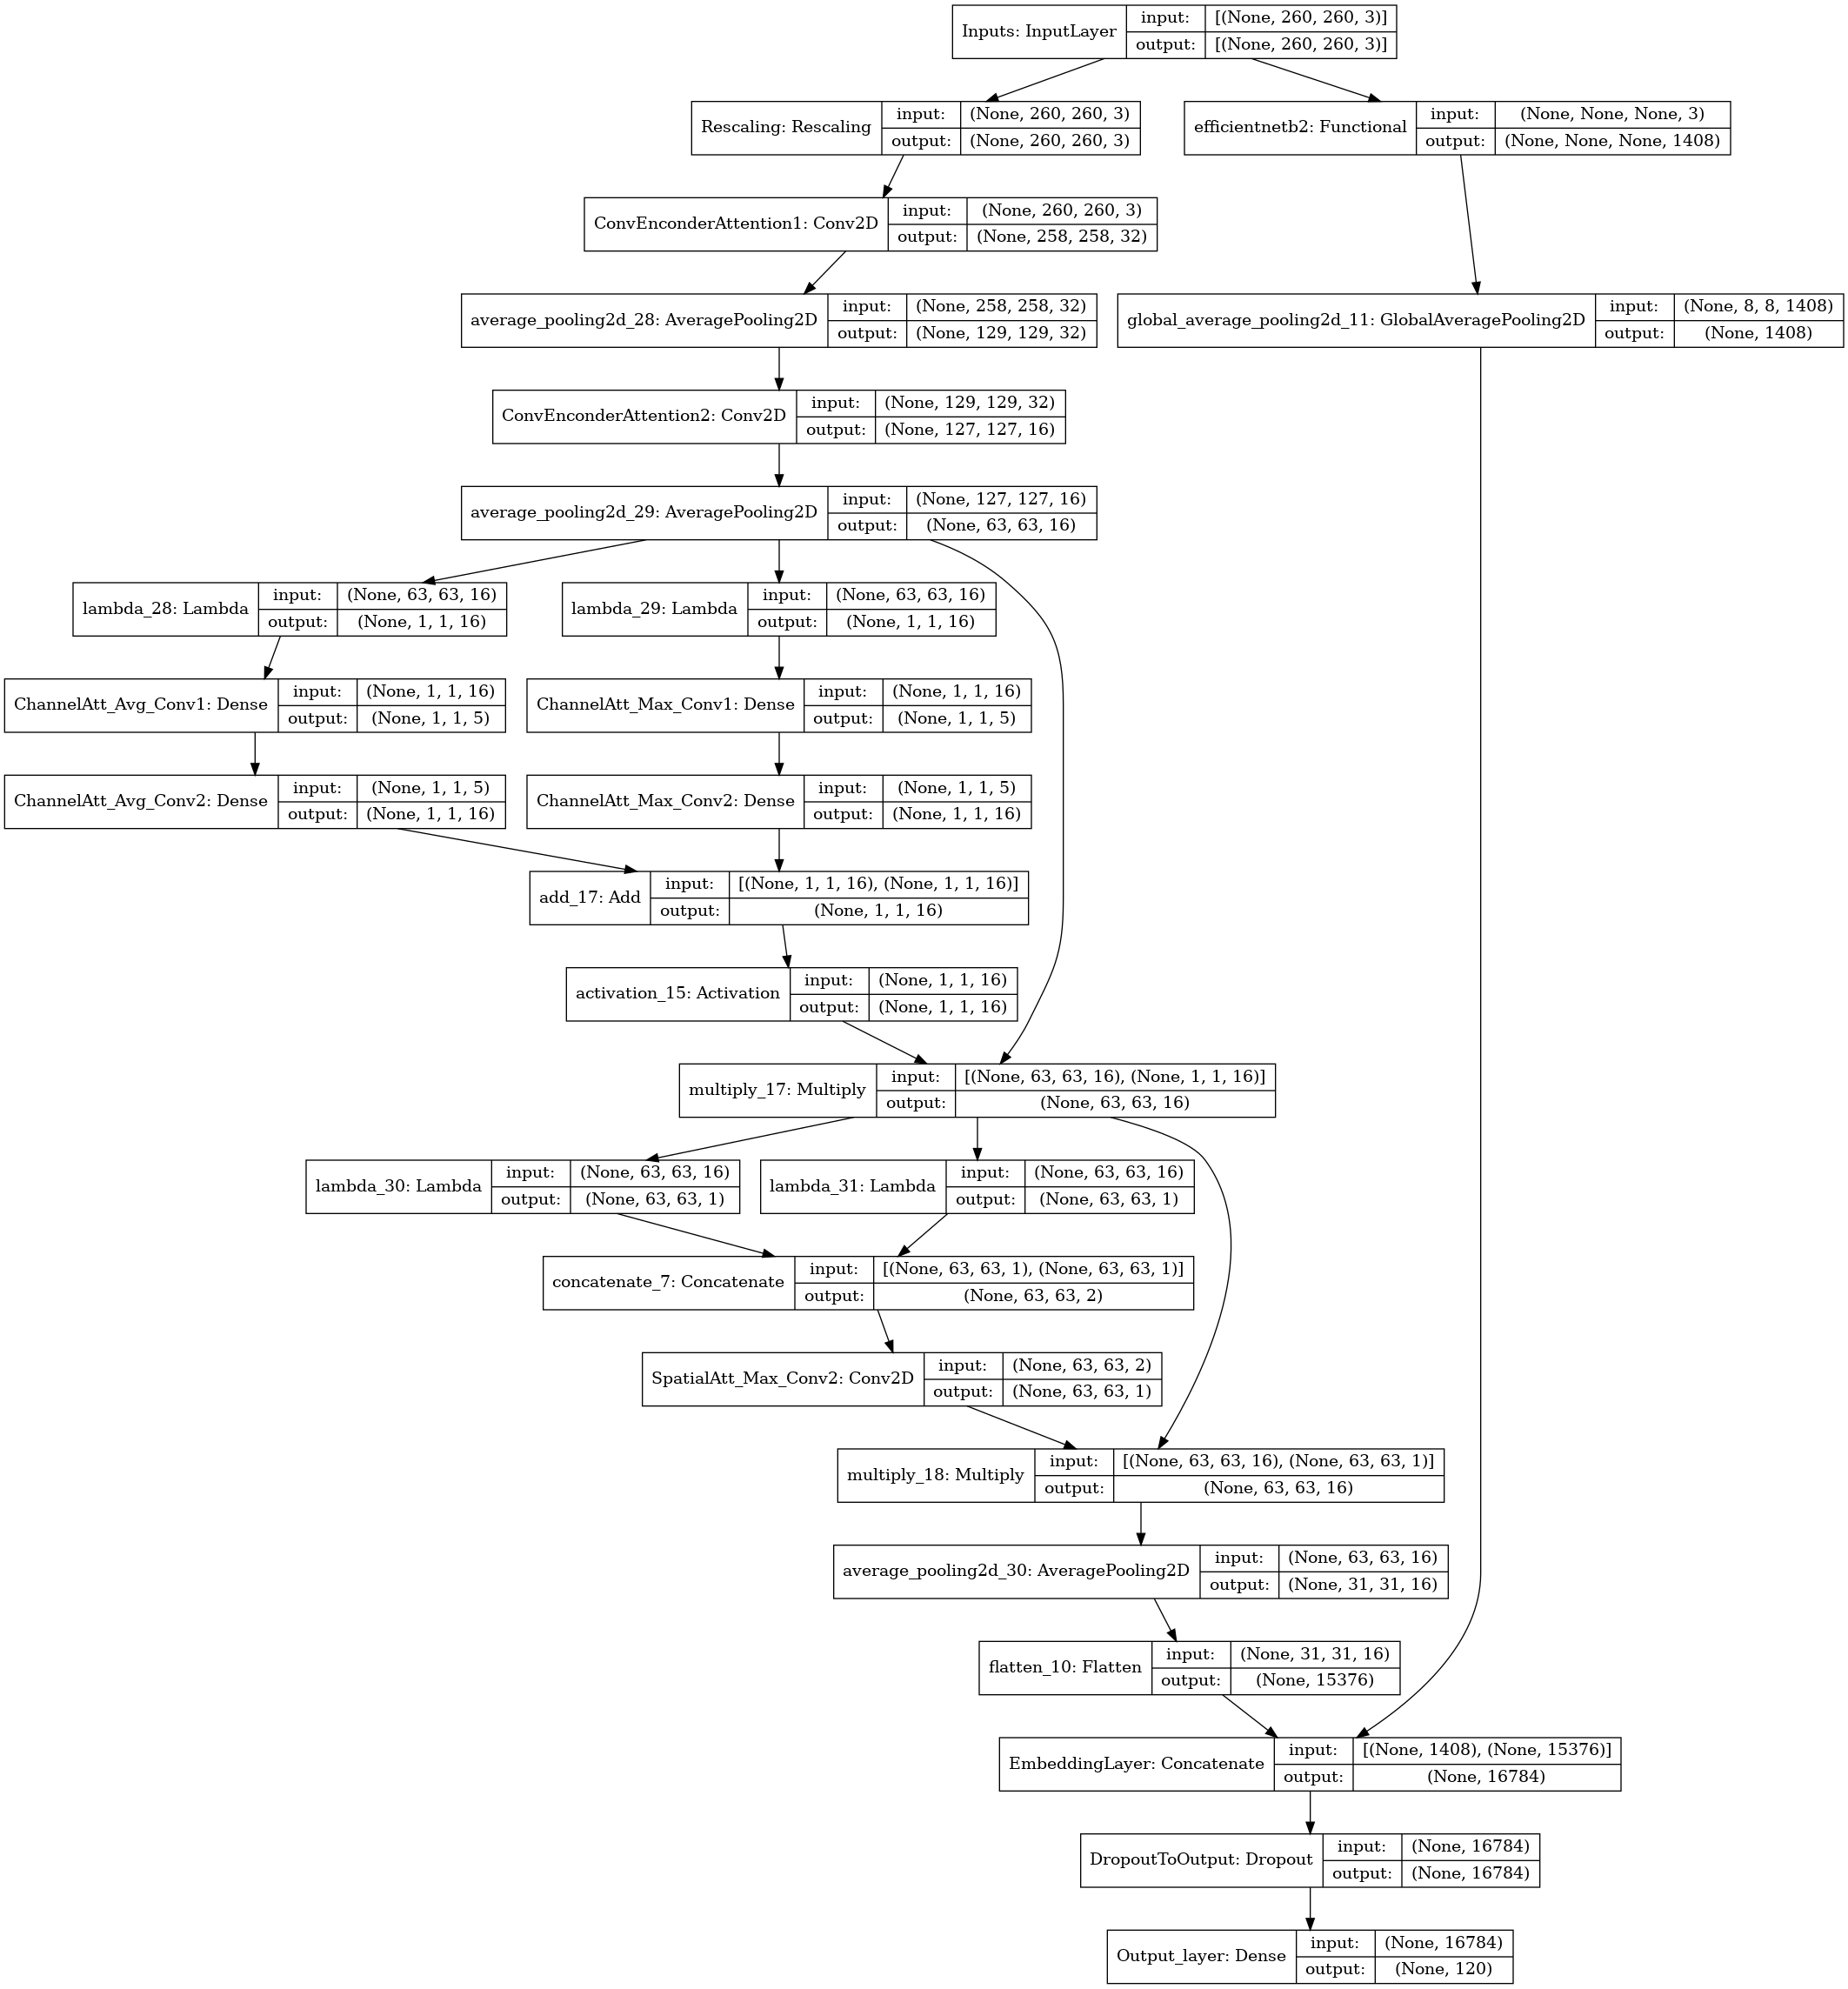

In [50]:
plot_model(model_CBAM_Only, show_shapes=True)

In [51]:
# Set checkpoint path
checkpoint_path = "/pechpoints_weights/checkpoint_CBAM.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         verbose=1,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch", monitor="val_accuracy")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.10,patience=4, verbose=1)

early_stopper = tf.keras.callbacks.EarlyStopping(patience=6, 
                                                 restore_best_weights=True,
                                                 monitor="val_accuracy")
initial_epochs = 15
CBAMHistory = model_CBAM_Only.fit(train_ds,
                                   epochs=initial_epochs,
                                   steps_per_epoch=len(train_ds),
                                   validation_data = val_ds,
                                   callbacks=[checkpoint_callback, reduce_lr, early_stopper])

Epoch 1/15
515/515 [==============================] - ETA: 0s - loss: 1.3931 - accuracy: 0.7950

Cleanup called...


515/515 [==============================] - 117s 182ms/step - loss: 1.3931 - accuracy: 0.7950 - val_loss: 0.6676 - val_accuracy: 0.8778

Epoch 00001: val_accuracy improved from -inf to 0.87779, saving model to /pechpoints_weights/checkpoint_CBAM.ckpt
Epoch 2/15
515/515 [==============================] - ETA: 0s - loss: 0.5937 - accuracy: 0.8980

Cleanup called...


515/515 [==============================] - 90s 174ms/step - loss: 0.5937 - accuracy: 0.8980 - val_loss: 0.6199 - val_accuracy: 0.8810

Epoch 00002: val_accuracy improved from 0.87779 to 0.88095, saving model to /pechpoints_weights/checkpoint_CBAM.ckpt
Epoch 3/15
515/515 [==============================] - ETA: 0s - loss: 0.5195 - accuracy: 0.9245

Cleanup called...


515/515 [==============================] - 96s 184ms/step - loss: 0.5195 - accuracy: 0.9245 - val_loss: 0.6183 - val_accuracy: 0.8785

Epoch 00003: val_accuracy did not improve from 0.88095
Epoch 4/15
515/515 [==============================] - ETA: 0s - loss: 0.4688 - accuracy: 0.9418

Cleanup called...


515/515 [==============================] - 89s 172ms/step - loss: 0.4688 - accuracy: 0.9418 - val_loss: 0.6279 - val_accuracy: 0.8788

Epoch 00004: val_accuracy did not improve from 0.88095
Epoch 5/15
515/515 [==============================] - ETA: 0s - loss: 0.4206 - accuracy: 0.9631

Cleanup called...


515/515 [==============================] - 91s 175ms/step - loss: 0.4206 - accuracy: 0.9631 - val_loss: 0.6496 - val_accuracy: 0.8710

Epoch 00005: val_accuracy did not improve from 0.88095
Epoch 6/15
515/515 [==============================] - ETA: 0s - loss: 0.3806 - accuracy: 0.9781

Cleanup called...


515/515 [==============================] - 89s 172ms/step - loss: 0.3806 - accuracy: 0.9781 - val_loss: 0.6541 - val_accuracy: 0.8681

Epoch 00006: val_accuracy did not improve from 0.88095

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/15
515/515 [==============================] - ETA: 0s - loss: 0.3505 - accuracy: 0.9880

Cleanup called...


515/515 [==============================] - 89s 172ms/step - loss: 0.3505 - accuracy: 0.9880 - val_loss: 0.6572 - val_accuracy: 0.8693

Epoch 00007: val_accuracy did not improve from 0.88095
Epoch 8/15
515/515 [==============================] - ETA: 0s - loss: 0.3422 - accuracy: 0.9919

Cleanup called...


515/515 [==============================] - 89s 172ms/step - loss: 0.3422 - accuracy: 0.9919 - val_loss: 0.6610 - val_accuracy: 0.8693

Epoch 00008: val_accuracy did not improve from 0.88095


### CBAM Fine tuning (last 10% layers)

In [52]:
model_CBAM_Only.load_weights(checkpoint_path) # Load best weights

# Reinstantiate Callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,patience=4, verbose=1)
early_stopper = tf.keras.callbacks.EarlyStopping(patience=5, 
                                                 restore_best_weights=True,
                                                 monitor="val_accuracy")
with strategy.scope():
    # Unfreeze all of the layer in the base model
    base_model.trainable = True
    
    to_unfreeze = round(len(base_model.layers)*0.10)
    print(f"Trainable layers of our base model: {to_unfreeze}\n")
    # Refreeze every layer except the last 10%
    for layer in base_model.layers[:-to_unfreeze]:
        layer.trainable = False
    
    # Recompile model 
    model_CBAM_Only.compile(loss=tf.keras.losses.categorical_crossentropy,
                    optimizer= tf.keras.optimizers.Adam(CBAMHistory.history['lr'][-1]*.1),
                    metrics=["accuracy"])

    fine_tune_epochs = initial_epochs+15

    fine_tuned_CBAMHistory = model_CBAM_Only.fit(train_ds,
                                                  epochs=fine_tune_epochs,
                                                  initial_epoch= CBAMHistory.epoch[-1]+1,
                                                  validation_data = val_ds,
                                                  callbacks=[checkpoint_callback, reduce_lr, early_stopper])

Trainable layers of our base model: 34

Epoch 9/30
515/515 [==============================] - ETA: 0s - loss: 0.2465 - accuracy: 0.9285

Cleanup called...


515/515 [==============================] - 121s 199ms/step - loss: 0.2465 - accuracy: 0.9285 - val_loss: 0.3502 - val_accuracy: 0.8897

Epoch 00009: val_accuracy improved from 0.88095 to 0.88970, saving model to /pechpoints_weights/checkpoint_CBAM.ckpt
Epoch 10/30
515/515 [==============================] - ETA: 0s - loss: 0.2108 - accuracy: 0.9346

Cleanup called...


515/515 [==============================] - 99s 192ms/step - loss: 0.2108 - accuracy: 0.9346 - val_loss: 0.3455 - val_accuracy: 0.8907

Epoch 00010: val_accuracy improved from 0.88970 to 0.89067, saving model to /pechpoints_weights/checkpoint_CBAM.ckpt
Epoch 11/30
515/515 [==============================] - ETA: 0s - loss: 0.1922 - accuracy: 0.9397

Cleanup called...


515/515 [==============================] - 100s 193ms/step - loss: 0.1922 - accuracy: 0.9397 - val_loss: 0.3439 - val_accuracy: 0.8890

Epoch 00011: val_accuracy did not improve from 0.89067
Epoch 12/30
515/515 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.9450

Cleanup called...


515/515 [==============================] - 99s 191ms/step - loss: 0.1767 - accuracy: 0.9450 - val_loss: 0.3437 - val_accuracy: 0.8880

Epoch 00012: val_accuracy did not improve from 0.89067
Epoch 13/30
515/515 [==============================] - ETA: 0s - loss: 0.1642 - accuracy: 0.9490

Cleanup called...


515/515 [==============================] - 99s 191ms/step - loss: 0.1642 - accuracy: 0.9490 - val_loss: 0.3439 - val_accuracy: 0.8870

Epoch 00013: val_accuracy did not improve from 0.89067
Epoch 14/30
515/515 [==============================] - ETA: 0s - loss: 0.1503 - accuracy: 0.9532

Cleanup called...


515/515 [==============================] - 99s 192ms/step - loss: 0.1503 - accuracy: 0.9532 - val_loss: 0.3479 - val_accuracy: 0.8861

Epoch 00014: val_accuracy did not improve from 0.89067

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000000474974515e-06.
Epoch 15/30
515/515 [==============================] - ETA: 0s - loss: 0.1352 - accuracy: 0.9592

Cleanup called...


515/515 [==============================] - 98s 189ms/step - loss: 0.1352 - accuracy: 0.9592 - val_loss: 0.3477 - val_accuracy: 0.8870

Epoch 00015: val_accuracy did not improve from 0.89067


In [53]:
# load best weights
model_CBAM_Only.load_weights(checkpoint_path)
# Save model and load
model_CBAM_Only.save("OnlyCBAM")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [54]:
print(f"Best Model Validation Accuracy: {model_CBAM_Only.evaluate(val_ds, verbose=0)[1]}")

Cleanup called...


Best Model Validation Accuracy: 0.8906705379486084


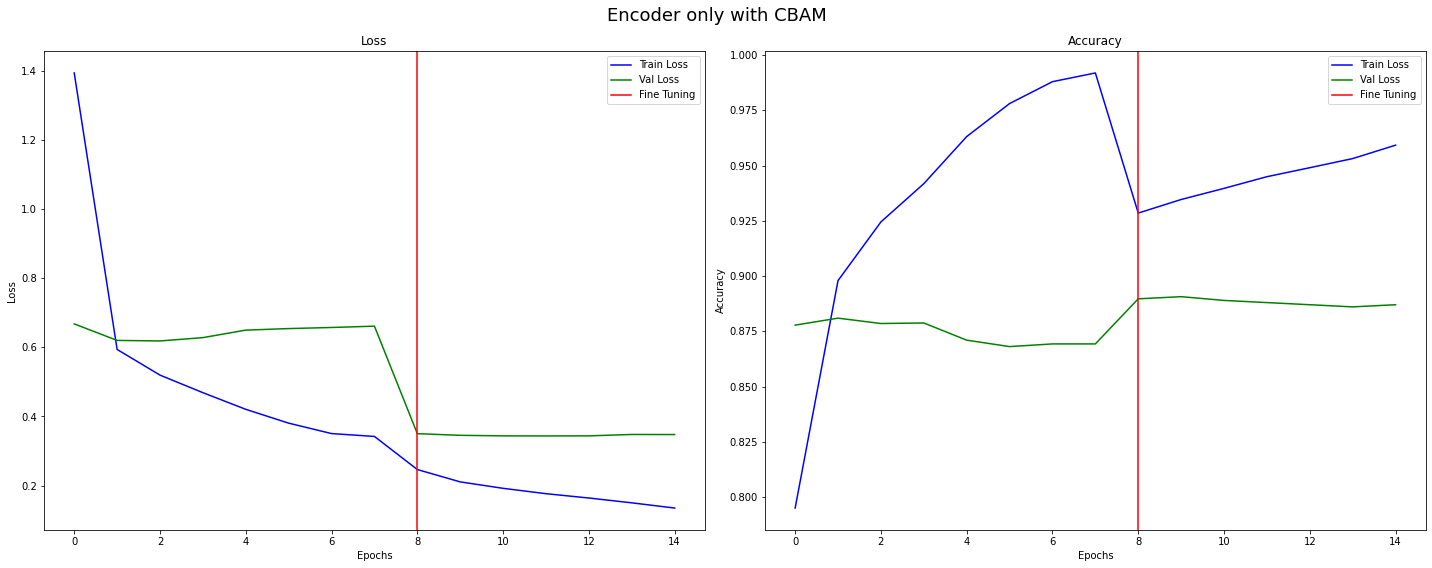

In [55]:
plotModelsCurves(CBAMHistory, fine_tuned_CBAMHistory, model_name="Encoder only with CBAM")

## Evaluate Best Validation Accuracy

In [56]:
val_results = {"FerNet (AttentionEncoder)": FerNetEffNetB2_Loaded.evaluate(val_ds, verbose=0)[1],
 "CBAM+EffNetB2+OutputLayers": model_CBAM_Only.evaluate(val_ds, verbose=0)[1],
 "LKA+EffNetB2+OutputLayers": model_LKA_Only.evaluate(val_ds, verbose=0)[1],
 "EffNetB2+OutputLayers": effb2.evaluate(val_ds, verbose=0)[1]}

acc_results = pd.DataFrame(val_results.values(), index=val_results.keys(), columns=["Validation Accuracy"])\
.sort_values(by="Validation Accuracy",ascending=False)
print(acc_results)

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


                            Validation Accuracy
FerNet (AttentionEncoder)              0.895044
EffNetB2+OutputLayers                  0.891399
CBAM+EffNetB2+OutputLayers             0.890671
LKA+EffNetB2+OutputLayers              0.888241


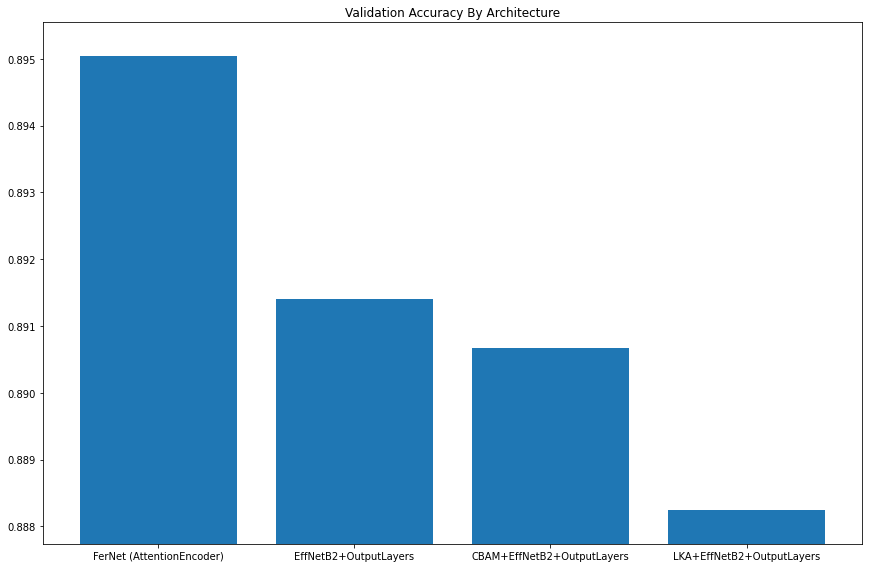

In [57]:
plt.figure(figsize=(12,8))
plt.title("Validation Accuracy By Architecture")
plt.bar(acc_results.index, acc_results["Validation Accuracy"])
plt.tight_layout()
plt.ylim(acc_results["Validation Accuracy"].min()-0.0005, acc_results["Validation Accuracy"].max()+0.0005)
plt.plot();